In [7]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import geopandas as gpd
from bs4 import BeautifulSoup 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from functools import reduce
from glob import glob
import copy
from math import ceil

import importlib

import utils.data
import utils.thresholds
import utils.plotting_utils
import utils.HRI

importlib.reload(utils.data)
importlib.reload(utils.thresholds)
importlib.reload(utils.plotting_utils)
importlib.reload(utils.HRI)

import utils.data as Data
import utils.thresholds as Thresholds
import utils.plotting_utils as PlottingUtils
import utils.HRI as HRI

# import planning area

,Name,PLN_AREA_N,PLN_AREA_C,REGION_N,REGION_C,geometry
0,kml_1,BEDOK,BD,EAST REGION,ER,"POLYGON Z ((103.93208 1.30555 0, 103.93208 1.3..."
1,kml_2,BOON LAY,BL,WEST REGION,WR,"POLYGON Z ((103.72042 1.32824 0, 103.72003 1.3..."
2,kml_3,BUKIT BATOK,BK,WEST REGION,WR,"POLYGON Z ((103.76408 1.37001 0, 103.76444 1.3..."
3,kml_4,BUKIT MERAH,BM,CENTRAL REGION,CR,"POLYGON Z ((103.82361 1.26018 0, 103.82362 1.2..."
4,kml_5,BUKIT PANJANG,BP,WEST REGION,WR,"POLYGON Z ((103.77445 1.39029 0, 103.77499 1.3..."


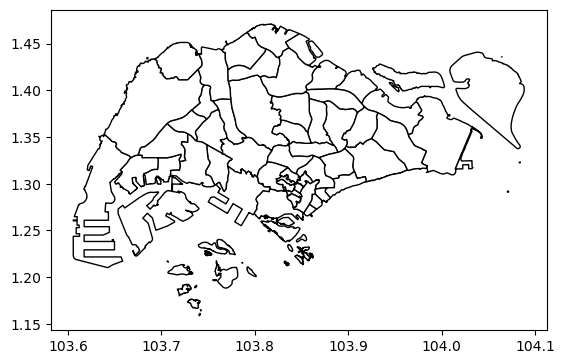

In [8]:
planningArea_shp = Data.import_planning_area()
planningArea_shp.plot(fc='white',ec='k')
planningArea_shp.head()

# Import data

In [9]:
risk_imported_df = Data.import_data(data_dir = r"Risk_Data_Imputed")
risk_df = Data.consolidate_df(risk_imported_df, normalise=None)
risk_df

{'DayTime': {'Capacity':                  PLN_AREA_N  AC Ownership  \
  0                ANG MO KIO      0.799718   
  1                     BEDOK      0.818013   
  2                    BISHAN      0.846697   
  3                  BOON LAY           NaN   
  4               BUKIT BATOK      0.808627   
  5               BUKIT MERAH      0.807521   
  6             BUKIT PANJANG      0.813607   
  7               BUKIT TIMAH      0.890988   
  8   CENTRAL WATER CATCHMENT           NaN   
  9                    CHANGI      1.000000   
  10               CHANGI BAY      0.000000   
  11            CHOA CHU KANG      0.819144   
  12                 CLEMENTI      0.826207   
  13            DOWNTOWN CORE      0.880414   
  14                  GEYLANG      0.799025   
  15                  HOUGANG      0.809357   
  16              JURONG EAST      0.803623   
  17              JURONG WEST      0.805303   
  18                  KALLANG      0.806843   
  19             LIM CHU KANG      0.

## Normalisation and imputation

- try out with different normalisation
    - perc: Can stretch out small variations across planning areas
    - min_max: Can stretch out small variations across planning areas, but min values will show as 0
    - max_scaling: Doesn't stretch out the small variations, so planningareas may have very similar values

In [10]:
def normalisation_imputation_df(risk_imported_df, normalise="max_scaling"):
    # initialise df for storing normalised and imputed data
    risk_norm_df = Data.consolidate_df(risk_imported_df, normalise=normalise)
    risk_norm = copy.deepcopy(risk_norm_df)
    risk_norm_imputed = copy.deepcopy(risk_norm_df)
    # invert 'Comprehensive Medical Treatment Accessibility' because higher travel time means lower capacity
    for HRI_time, HRI_time_dict in risk_norm_df.items():
        for petal, petal_df in HRI_time_dict.items():
            if petal == "Capacity":
                # flip relationship
                risk_norm[HRI_time][petal]['Comprehensive Medical Treatment Accessibility'] = 100 - petal_df['Comprehensive Medical Treatment Accessibility']
                risk_norm_imputed[HRI_time][petal]['Comprehensive Medical Treatment Accessibility'] = 100 - petal_df['Comprehensive Medical Treatment Accessibility']
                # print(f"{HRI_time}: {risk_norm[HRI_time][petal]['Comprehensive Medical Treatment Accessibility'].values[0]}")
            # then impute NAs with 0th normentile
            risk_norm_imputed[HRI_time][petal] = risk_norm_imputed[HRI_time][petal].fillna(0)

    return {"raw_df":risk_norm_df, "norm_df":risk_norm, "norm_df_imputed": risk_norm_imputed}

risk_dfs = dict()
for normalise in ["perc","min_max","max_scaling"]:
    risk_dfs[normalise] = normalisation_imputation_df(risk_imported_df, normalise=normalise)

risk_dfs

{'perc': {'raw_df': {'DayTime': {'Capacity':                  PLN_AREA_N  AC Ownership  \
    0                ANG MO KIO     22.222222   
    1                     BEDOK     48.888889   
    2                    BISHAN     66.666667   
    3                  BOON LAY           NaN   
    4               BUKIT BATOK     35.555556   
    5               BUKIT MERAH     31.111111   
    6             BUKIT PANJANG     42.222222   
    7               BUKIT TIMAH     73.333333   
    8   CENTRAL WATER CATCHMENT           NaN   
    9                    CHANGI     90.000000   
    10               CHANGI BAY      6.666667   
    11            CHOA CHU KANG     53.333333   
    12                 CLEMENTI     57.777778   
    13            DOWNTOWN CORE     71.111111   
    14                  GEYLANG     20.000000   
    15                  HOUGANG     37.777778   
    16              JURONG EAST     24.444444   
    17              JURONG WEST     26.666667   
    18                  KALL

In [11]:
# X = risk_df['DayTime']['Capacity']['Comprehensive Medical Treatment Accessibility'].values
# for k in risk_dfs.keys():
#     Y = risk_dfs[k]['norm_df_imputed']['DayTime']['Capacity']['Comprehensive Medical Treatment Accessibility'].values
#     print([f"{x:.2f},{y:.2f}" for x,y in sorted(zip(X, Y), key=lambda pair: pair[0])])

# Import Weights and thresholds
- Thresholds values for DayTime and NightTime HRI will be different because value distribution of DayTime and NightTime HRI is different, and therefore min max values for normalisation will be different
- But that's ok because DayTime and NightTime HRI are not comparable
- 2 threshold values will map to 3 HRI categories

In [12]:
daytime_weights = pd.read_csv(Data.DAYTIME_WEIGHTS_FP)
nighttime_weights = pd.read_csv(Data.NIGHTTIME_WEIGHTS_FP)
petal_weights = pd.read_csv(Data.PETAL_WEIGHTS_FP)
thresholds = pd.read_csv(Data.THRESHOLDS_FP)
daytime_weights

,Petal,Variable,Conditional Factor,Vulnerability Factor Score,Conditional Vulnerability Score,Weight
0,Sensitivity,Prepubescent Population,4,3,12,17.391304
1,Sensitivity,Elderly Population,4,2,8,11.594203
2,Sensitivity,Socially Isolated,4,1,4,5.797101
3,Sensitivity,Functionally Disabled,4,1,4,5.797101
4,Capacity,Financial Capacity,2,5,10,14.492754
5,Capacity,AC Ownership,1,4,4,5.797101
6,Capacity,Minor Medical Treatment Availability,1,4,4,5.797101
7,Capacity,Comprehensive Medical Treatment Accessibility,1,5,5,7.246377
8,Capacity,Shade Potential,3,3,9,13.043478
9,Capacity,Public Transport Accessibility,3,3,9,13.043478


In [13]:
thresholds_dict = {n: {i: None for i in risk_df.keys()} for n in ["perc","min_max","max_scaling"]}
for normalise in ["perc","min_max","max_scaling"]:
    for HRI_time in risk_df.keys():
        GT = Thresholds.GetThresholds(thresholds = thresholds,
                            risk_df = Data.consolidate_petals(risk_df)[HRI_time],
                            invert_vars = ['Comprehensive Medical Treatment Accessibility'])
        thresholds_df = GT.mapping_thresholds_specified(thresholds=thresholds,
                                                        normalise=normalise)
        thresholds_dict[normalise][HRI_time] = thresholds_df

thresholds_dict['max_scaling']['DayTime']

Min TA
Hottest WBGT
Min TA
Nighttime Population
nan
Hottest WBGT
Daytime Population
nan
Min TA
Nighttime Population
nan
Hottest WBGT
Daytime Population
nan


,Variable,lower_break,upper_break
1,Elderly Population,40.798198,61.197297
7,Comprehensive Medical Treatment Accessibility,48.443370,61.332528
10,Hottest WBGT,90.964510,96.833188
0,Prepubescent Population,1.655685,39.313900
2,Socially Isolated,29.588526,49.122744
3,Functionally Disabled,67.650473,89.944616
4,Financial Capacity,40.000000,100.000000
5,AC Ownership,80.530288,89.109658
6,Minor Medical Treatment Availability,14.017774,48.365235
8,Shade Potential,41.134263,66.282329


In [14]:
# demonstration of threshold values when all observed data exceeds threshold values
print(risk_df['NightTime']['Hazard'].min())
for k in risk_dfs.keys():
    x = thresholds_dict[k]['NightTime']
    x = x[x['Variable'] == 'Min TA']
    print(f"thresholds: {x}")
    print(k,risk_dfs[k]['norm_df']['NightTime']['Hazard']['Min TA'].min())

PLN_AREA_N    ANG MO KIO
Min TA         26.892457
dtype: object
thresholds:    Variable  lower_break  upper_break
11   Min TA          0.0          0.0
perc 1.8181818181818181
thresholds:    Variable  lower_break  upper_break
11   Min TA  -223.716035   -44.292075
min_max 0.0
thresholds:    Variable  lower_break  upper_break
11   Min TA    84.661494    93.163067
max_scaling 95.26174057443923


### Multiply Weights with Variables
$$ HRI = H^{W_H} \times E^{W_E} \times V^{W_V}$$

$$ = H^{W_H} \times E^{W_E} \times (\frac{S}{C})^{W_V}$$

$$ = H^{W_H} \times E^{W_E} \times [\frac{\sum_i s_i w_{s,i}}{\sum_i c_i w_{c,i}}]^{W_V}$$

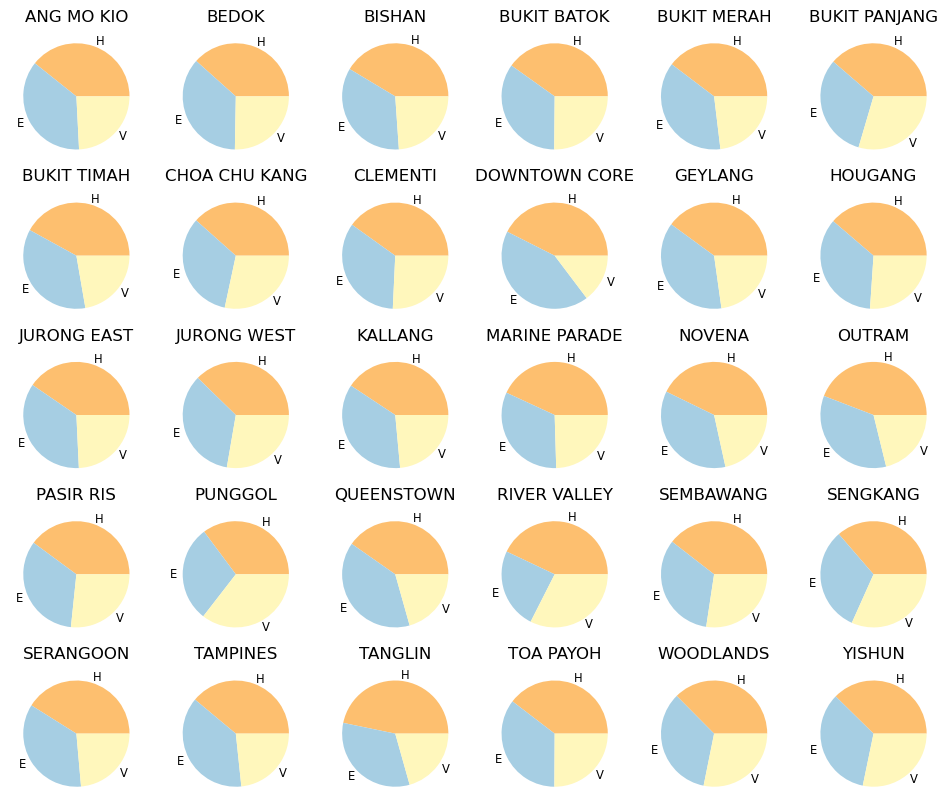

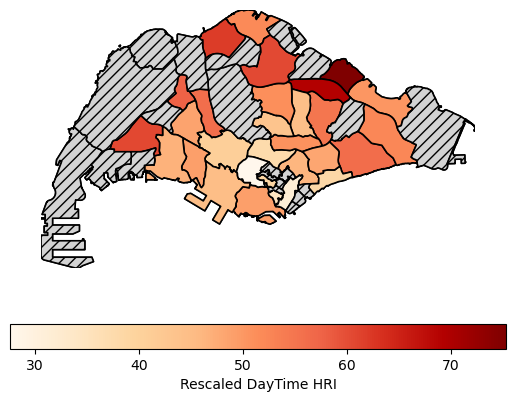

DayTime: [35.11840328754998, 51.93167425829851]


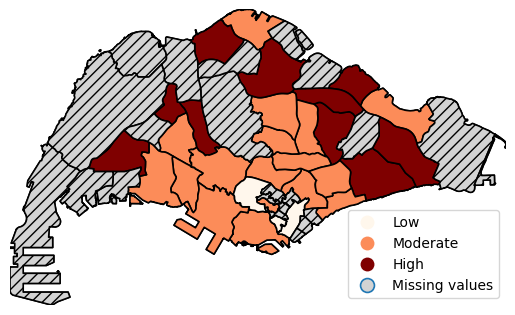

c:\Users\hypak\OneDrive - Singapore Management University\Documents\Projects\HRI\utils\plotting_utils.py:48: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  text = ax.text(j, i, f"{corr_array[i, j]:.3f}",


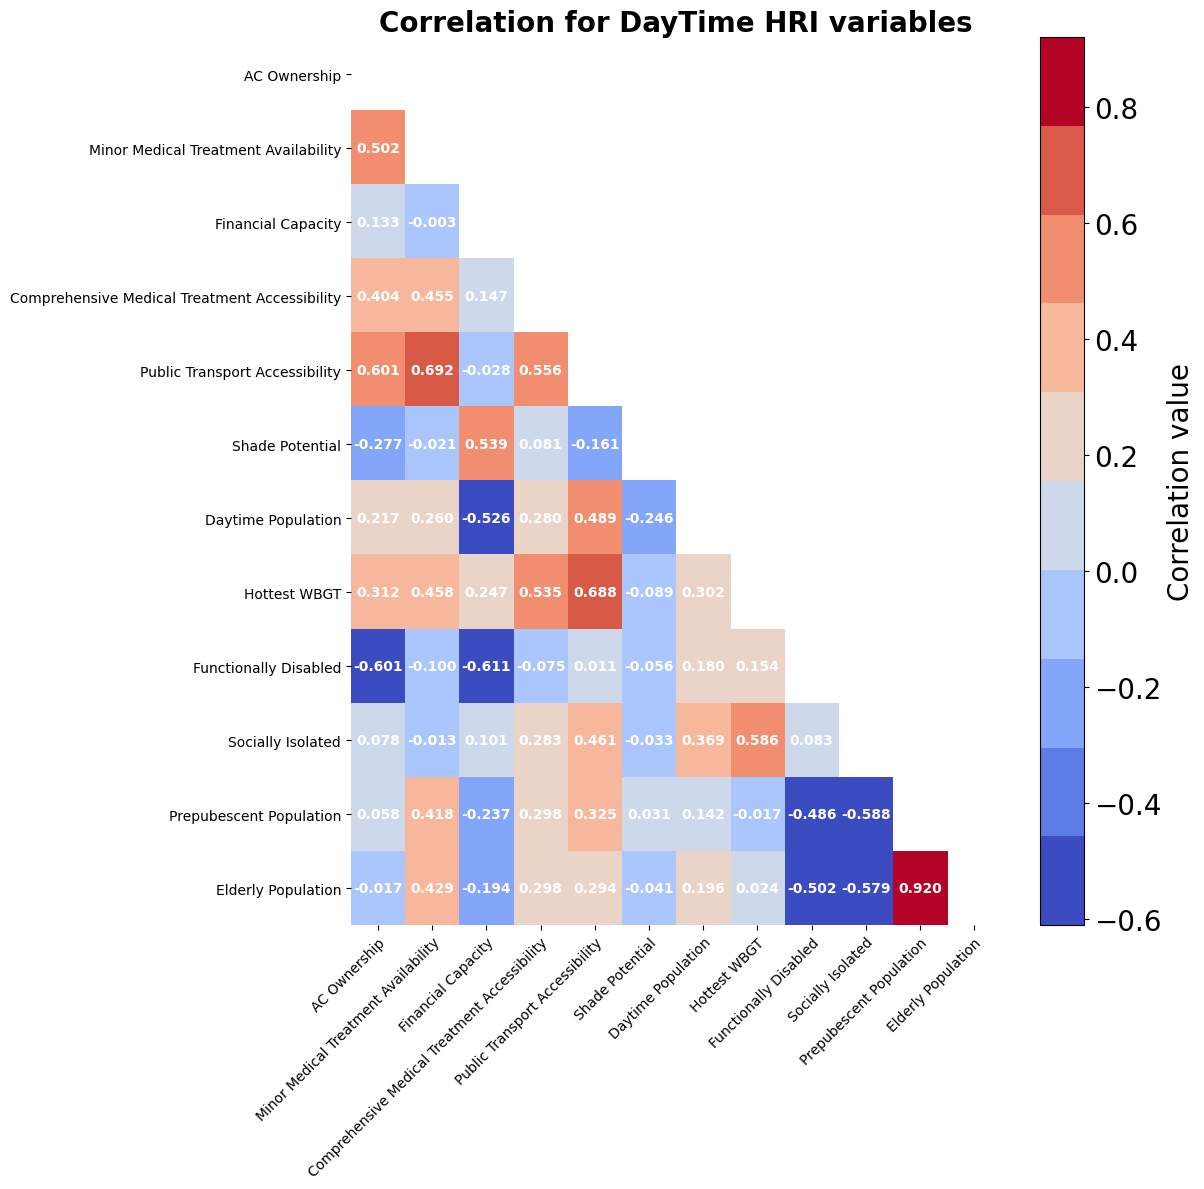

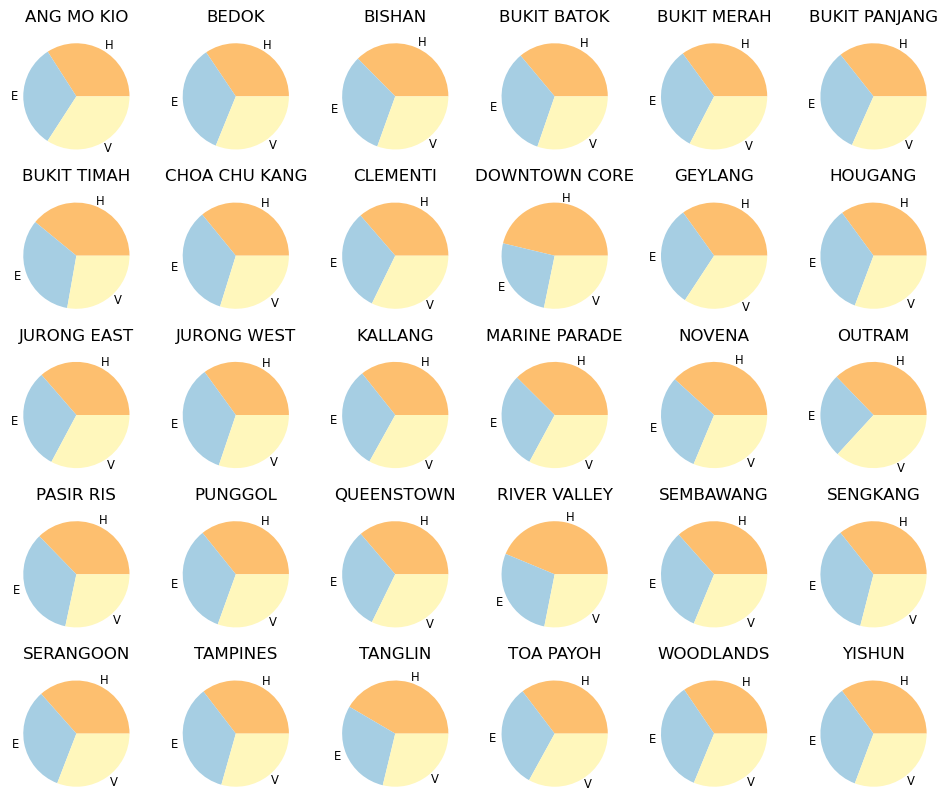

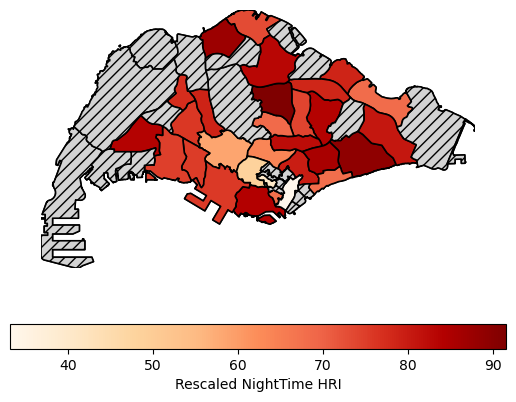

NightTime: [31.308327493959283, 64.32102583289797]


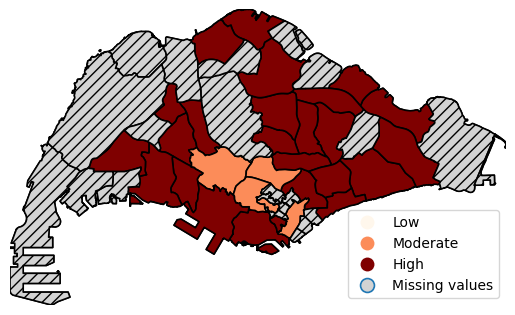

c:\Users\hypak\OneDrive - Singapore Management University\Documents\Projects\HRI\utils\plotting_utils.py:48: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  text = ax.text(j, i, f"{corr_array[i, j]:.3f}",


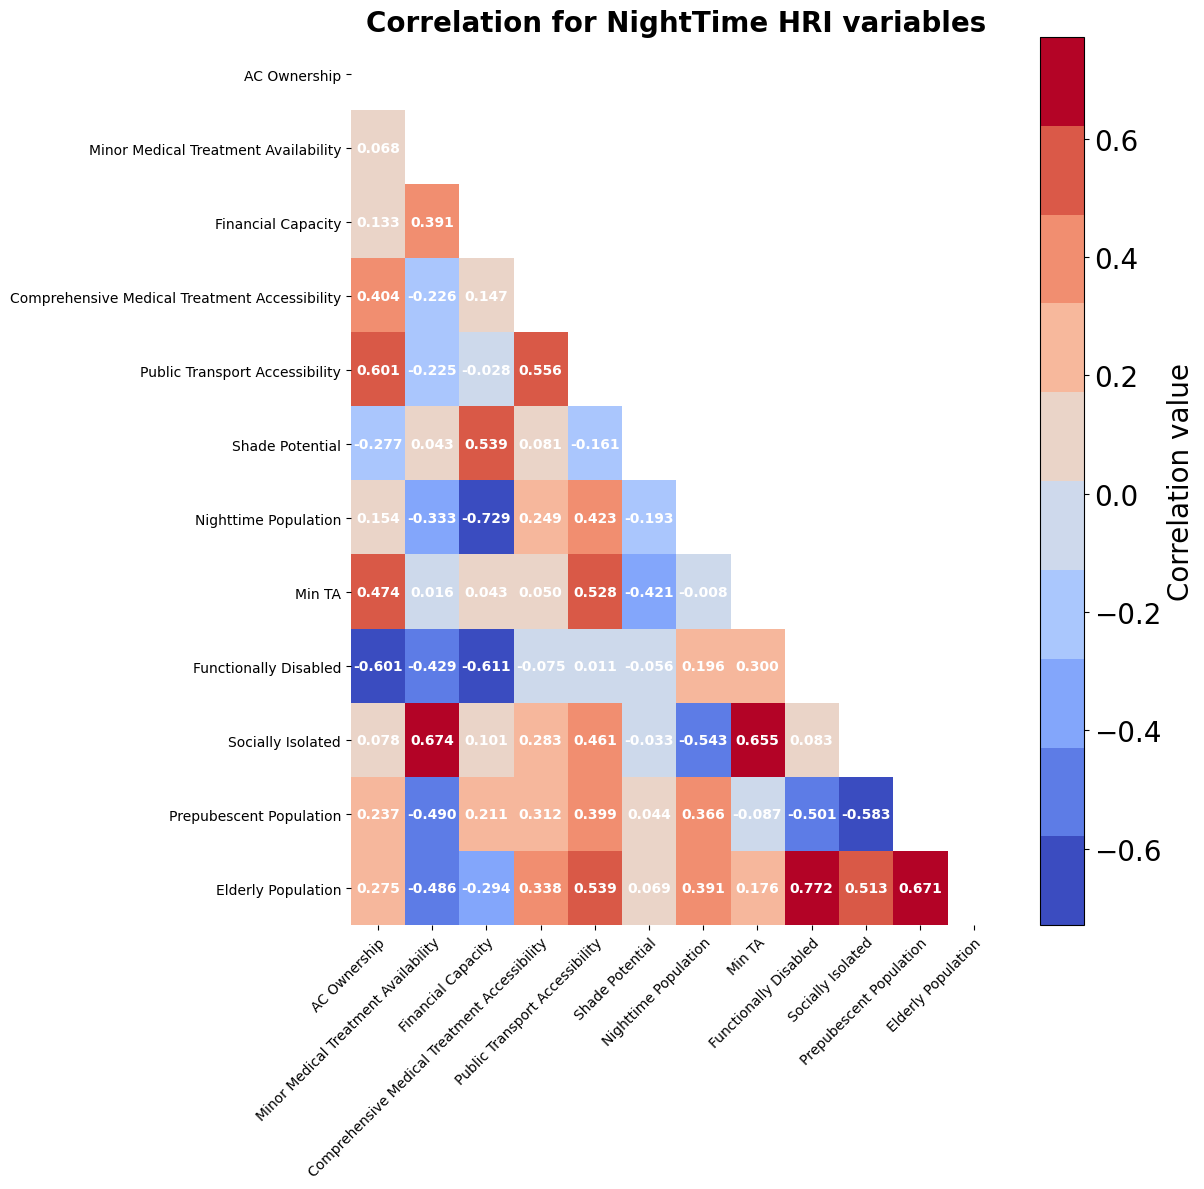

In [15]:
for HRI_time in ['DayTime','NightTime']:
       save_fp_prefix = f"HRI{HRI_time}"
       file_ext = ".svg"
       # input prarameters
       weights = daytime_weights if HRI_time == 'DayTime' else nighttime_weights

       # plot piechart
       # use norm_df instead of norm_df_imputed so all the planning areas with NaN values will be dropped
       HRIDay = HRI.HRICalculation(risk_dfs['max_scaling']['norm_df'][HRI_time], 
                     weights, petal_weights)
       # x.calculate_HRI_verbose()
       rescaled_HRI_df_verbose = HRIDay.plot_HRI_breakdown(save_fp = os.path.join(r"Exported_Data\exported_figures",f"{save_fp_prefix}Imputed_piechart{file_ext}"),
                            textprops={'size': 'smaller'})

       # HRIDay.calculate_subindex(petal="Sensitivity")
       # HRIDay.calculate_vulnerability_subindex()
       # HRIDay.calculate_HRI()
       # plot HRI map
       planningArea_mainland, bbox = PlottingUtils.get_sgMainland_bbox()

       ax = planningArea_mainland.plot(fc="none")
       HRIDay.plot_HRI(planningArea=planningArea_mainland,
              ax=ax,legend=True, cmap='OrRd',linewidth=1.2,ec="k",
              missing_kwds={
                     "color": "lightgrey",
                     "hatch": "///",
                     "label": "Missing values",
              },
              legend_kwds={"label": f"Rescaled {HRI_time} HRI", "orientation": "horizontal"})
       ax.axis('off')
       ax.set_ylim(bbox[1],bbox[3])
       ax.set_xlim(bbox[0],bbox[2])
       # continuous HRI values map
       plt.savefig(os.path.join(r"Exported_Data\exported_figures",f"{save_fp_prefix}Imputed_contMap{file_ext}"), 
              bbox_inches = 'tight')
       plt.show()

       # export csvs
       HRI_df = HRIDay.calculate_HRI()
       HRI_df.to_csv(os.path.join(r"Exported_Data",f"{save_fp_prefix}Imputed.csv"))
       rescaled_HRI_df_verbose.to_csv(os.path.join(r"Exported_Data",f"{save_fp_prefix}Imputed_piechartBreakdown.csv"))
       # # get verbose HRI_df
       HRI_df_verbose = HRIDay.get_HRI_df()
       HRI_df_verbose["Vulnerability"] = HRI_df_verbose["Sensitivity"]/HRI_df_verbose["Capacity"]
       HRI_df_verbose.to_csv(os.path.join(r"Exported_Data",f"{save_fp_prefix}Imputed_verbose.csv"))

       # apply thresholds to HRI
       # # make threshold to same format as HRI df so we can reuse the function
       HRI_thresholds_df = Thresholds.convert_threshold_to_HRI_df(thresholds_dict['max_scaling'][HRI_time], 
                                   risk_dfs['max_scaling']['norm_df'][HRI_time])

       HRIDay = HRI.HRICalculation(HRI_thresholds_df, weights, petal_weights)
       # get HRI thresholds
       HRI_thresholds = HRIDay.calculate_HRI()
       print(f"{HRI_time}: {HRI_thresholds['rescaled_HRI'].to_list()}")
       HRI_thresholds_verbose = HRIDay.get_HRI_df()
       # apply threshold to each petal
       HRI_thresholds_verbose.apply(lambda x: pd.cut(HRI_df_verbose[x.name], [0] + x.to_list() + [100], 
                                   labels=["Low", "Moderate", "High"]), 
                                   axis=0).to_csv(os.path.join(r"Exported_Data",f"{save_fp_prefix}Imputed_thresholded_verbose.csv"))

       # plot categorical map
       threshold_plot = copy.deepcopy(planningArea_mainland)
       threshold_plot = threshold_plot.merge(
       pd.cut(HRI_df['rescaled_HRI'], [0] + HRI_thresholds['rescaled_HRI'].to_list() + [100], 
              labels=["Low", "Moderate", "High"]).to_frame().reset_index(),
              on="PLN_AREA_N", how="inner")
       ax = planningArea_mainland.plot(fc="none")
       threshold_plot.plot(ax=ax, column="rescaled_HRI",
                     legend=True, cmap='OrRd',linewidth=1.2,ec="k",
                            missing_kwds={
                                   "color": "lightgrey",
                                   "hatch": "///",
                                   "label": "Missing values",
                            },
                            legend_kwds={'loc': 'lower right'})
       ax.axis('off')
       ax.set_ylim(bbox[1],bbox[3])
       ax.set_xlim(bbox[0],bbox[2])
       plt.savefig(os.path.join(r"Exported_Data\exported_figures",f"{save_fp_prefix}Imputed_thresholded{file_ext}"), 
              bbox_inches = 'tight')
       plt.show()

       # export HRI thresholded csv
       threshold_plot[["PLN_AREA_N","rescaled_HRI"]].to_csv(os.path.join(r"Exported_Data",f"{save_fp_prefix}Imputed_thresholded.csv"))

       # plot correlation plot
       PlottingUtils.correlation_plot(Data.consolidate_petals(risk_dfs['max_scaling']['norm_df'])[HRI_time].iloc[:,1:].corr(),
                title = f"Correlation for {HRI_time} HRI variables",
                 save_fp = os.path.join(r"Exported_Data\exported_figures",f"{save_fp_prefix}Imputed_correlation{file_ext}")
                 )